# Exploring Topic and Word Relationships

Here we explore different ways that the the newstest 2015 dataset can be looked at.

In [1]:
import math

def read_file(file_path, max_amount=math.inf):
    """
    Reads a number of lines from file and return list of lines
    :param file_path:
    :param max_amount:
    :return: list[str]
    """
    line_list = []

    with open(file=file_path) as f:
        curr_idx = 0
        while curr_idx < max_amount:
            line_list.append(f.readline())
            curr_idx += 1

    return line_list

print("Loading file")
l_raw = read_file('./trg.shuf', 1000000)
print("Finished loading in file")

Loading file
Finished loading in file


In [2]:
def import_vocab(vocab_file_path):
    vocab = []
    with open(file=vocab_file_path) as f:
        curr_idx = 0
        max_amount = 5000000
        lines = f.readlines()
        for line in lines:
            l = line.split()
            if len(l) == 2:
                vocab.append(l[0])
                curr_idx += 1
    return vocab

print("Loading vocab")
target_vocab = import_vocab("./lm.vocab.txt")
print("Loaded vocab. It is of size: " + str(len(target_vocab)))

target_vocab_dic = {}
for w in target_vocab:
    target_vocab_dic[w] = 0


Loading vocab
Loaded vocab. It is of size: 34909


In [68]:
import math
import pandas as pd
from collections import Counter
import operator
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))
import gensim
from gensim import corpora
nltk.download('words')
from nltk.corpus import words
import enchant


d = enchant.Dict("en_US")

wn_lemmas = set(words.words())




def process_word(word, remove_stop=True, lemmatize_and_morph=True):
    """
    Returns process word
    :param word:
    :return: str word
    """
    # lower
    word = word.lower()
    
    # Remove symbols
    if len(word) < 3:
        return None
    
    # Get morph
    if lemmatize_and_morph is True:
        t_word = wn.morphy(word)
        if t_word is not None:
            word = t_word

        # Get lemma
        word = WordNetLemmatizer().lemmatize(word)
    
    # Remove stop
    if remove_stop is True and word in en_stop:
        return None
    return word


def preprocess_all_words(word_list):
    ret = []
    for line in word_list:
        temp = []
        for word in line:
            w = process_word(word, remove_stop=True, lemmatize_and_morph=False)
            if w is not None:
                temp.append(w)
        ret.append(temp)
    return ret


def process_bpe(line_list, seq="@@", rm_words=["\n"], lemmatize_and_morph=True, vocab_dictionary=None):
    """
    Transforms line list form read_file to list[list[str=words]], and bpe words merged together
    :param line_list:
    :param seq:
    :param rm_words:
    :return: list[list[str=words]]
    """
    word_to_bpe_mapping = {}  # word -> [bpe1, bpe2, ...]
    
    full_word_list = []
    for line in line_list:
        temp_words = line.split()
        full_words = []
        idx = 0
        while idx < len(temp_words):
            if temp_words[idx].endswith(seq):
                temp_str = ""
                temp_mapping = []
                while temp_words[idx].endswith(seq):
                    addition = temp_words[idx][:-(len(seq))]
                    if vocab_dictionary is not None:
                        if addition in vocab_dictionary:
                            temp_str += addition
                            temp_mapping.append(addition)
                    else:
                        temp_str += addition
                    idx += 1
                addition = temp_words[idx]
                if vocab_dictionary is not None:
                    if addition in vocab_dictionary:
                        temp_str += addition
                        temp_mapping.append(addition)
                else:
                    temp_str += addition
                
                if temp_str not in rm_words:
                    w = process_word(temp_str, lemmatize_and_morph=lemmatize_and_morph)
                    if w is not None:
                        full_words.append(w)
                        if w not in word_to_bpe_mapping:
                            word_to_bpe_mapping[w] = []
                        word_to_bpe_mapping[w].extend(temp_mapping)
                idx += 1
            else:
                if temp_words[idx] not in rm_words:
                    if vocab_dictionary is not None:
                        if temp_words[idx] in vocab_dictionary:
                            w = process_word(temp_words[idx], lemmatize_and_morph=lemmatize_and_morph)
                            if w is not None:
                                full_words.append(w)
                                if w not in word_to_bpe_mapping:
                                    word_to_bpe_mapping[w] = []
                                word_to_bpe_mapping[w].extend([w])
                    else:
                        w = process_word(temp_words[idx], lemmatize_and_morph=lemmatize_and_morph)
                        if w is not None:
                            full_words.append(w)
                            if w not in word_to_bpe_mapping:
                                word_to_bpe_mapping[w] = []
                            word_to_bpe_mapping[w].extend([w])

                idx += 1
        full_word_list.append(full_words)
    return full_word_list, word_to_bpe_mapping


def process_bpe_to_list(line_list, vocab_dictionary, unk_token="<UNK>"):
    """
    Transforms line list to word list.
    """
    full_word_list = []
    full_word_list_no_UNK = []
    
    for line in line_list:
        temp_words = line.split()
        temp_new_line = []
        temp_new_unk_line = []
        
        for word in temp_words:
            if word in vocab_dictionary:
                temp_new_line.append(word)
                if word not in en_stop and len(word) > 2:
                    temp_new_unk_line.append(word)
            else:
                temp_new_line.append(unk_token)
                
        full_word_list.append(temp_new_line)
        full_word_list_no_UNK.append(temp_new_unk_line)
        
    return full_word_list, full_word_list_no_UNK


def get_word_count(word_list):
    """
    Returns word count.
    :param word_list:
    :return: List[(str=word, int=count)]
    """
    word_count = {}
    for line in word_list:
        for word in line:
            if word in word_count:
                word_count[word] += 1
            else:
                word_count[word] = 1

    return sorted(word_count.items(), key=operator.itemgetter(1))





num_topics = 20

import random
l = random.sample(l_raw, 50000)

print("Started training step")

#wl, word_to_bpe_mapping_small  = process_bpe(line_list=l, vocab_dictionary=target_vocab_dic)
wl, wl_clean = process_bpe_to_list(line_list=l, vocab_dictionary=target_vocab_dic, unk_token="<UNK>")
print("Vocab size train: " + str(len(get_word_count(word_list=wl))))

#wl_full, word_to_bpe_mapping = process_bpe(line_list=l_raw, lemmatize_and_morph=False, vocab_dictionary=target_vocab_dic)
wl_full, wl_full_clean = process_bpe_to_list(line_list=l_raw, vocab_dictionary=target_vocab_dic, unk_token="<UNK>")
vocab_size_full = len(get_word_count(word_list=wl_full))
print("Vocab size full: " + str(vocab_size_full))

dictionary = corpora.Dictionary(wl_full)
print("Finished Dictionary")

for w in word_to_bpe_mapping_small:
    if w in word_to_bpe_mapping:
        word_to_bpe_mapping[w].extend(word_to_bpe_mapping_small[w])
    else:
        word_to_bpe_mapping[w] = word_to_bpe_mapping_small[w]
        
for w in word_to_bpe_mapping:
    word_to_bpe_mapping[w] = list(set(word_to_bpe_mapping[w]))
print("Finished word2bpe mapping")



[nltk_data] Downloading package wordnet to /home/nikita/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/nikita/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /home/nikita/nltk_data...
[nltk_data]   Package words is already up-to-date!


Started training step
Vocab size train: 26757
Vocab size full: 30786
Finished Dictionary
Finished word2bpe mapping


In [69]:
def get_topics_lda(word_list, dictionary, num_topics):
    corpus = [dictionary.doc2bow(text) for text in word_list]
    print("Finished corpus")
    
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)
    topics = ldamodel.print_topics(num_words=4)
    print("Topics: ")
    for topic in topics:
        print(topic)

    return topics, ldamodel, corpus, dictionary

t, ldamodel,_, dictionary = get_topics_lda(word_list=wl, dictionary=dictionary, num_topics=num_topics)

Finished corpus
Topics: 
(0, '0.052*"," + 0.052*"." + 0.043*"to" + 0.032*"that"')
(1, '0.015*"45" + 0.011*"2003" + 0.011*"--" + 0.007*"Co@@"')
(2, '0.037*"=" + 0.028*";" + 0.025*"5@@" + 0.023*"+"')
(3, '0.015*"..." + 0.012*"11.@@" + 0.011*"Internet" + 0.010*"language"')
(4, '0.131*"the" + 0.057*"of" + 0.045*"to" + 0.031*"."')
(5, '0.223*""" + 0.022*"de" + 0.015*"said" + 0.014*"x"')
(6, '0.009*"delivery" + 0.007*"2.@@" + 0.007*"a@@" + 0.006*"ter"')
(7, '0.060*"?" + 0.039*"’" + 0.033*"s" + 0.033*"!"')
(8, '0.178*":" + 0.084*"," + 0.017*"2016" + 0.016*"00"')
(9, '0.059*"," + 0.016*"*" + 0.009*"T@@" + 0.007*"."')
(10, '0.178*"-" + 0.077*"/" + 0.048*"€" + 0.046*"%"')
(11, '0.015*"research" + 0.012*"key" + 0.010*"A" + 0.009*"word"')
(12, '0.045*":" + 0.043*"_" + 0.019*"4@@" + 0.018*"page"')
(13, '0.055*"the" + 0.049*"," + 0.044*"." + 0.035*"to"')
(14, '0.056*"\'" + 0.011*"per" + 0.010*"\'@@" + 0.009*"from"')
(15, '0.067*"," + 0.056*"the" + 0.052*"." + 0.050*"and"')
(16, '0.106*"the" + 0.067*

# Vocab Splitting

Here we get the vocab for each topic.

In [70]:
def get_representatives_lda(word_list, lda_model, dictionary, num_topics=10):
    max_line = [[]] * num_topics
    max_class = [0] * num_topics 
    class_vocab = {i:{} for i in range(0, num_topics)}
    docs = [[]] * num_topics
    
    for line, idx in zip(word_list, range(len(word_list))):
        #print(line)
        new_doc_bow = dictionary.doc2bow(line)
        s = ldamodel.get_document_topics(new_doc_bow)
        s.sort(key=lambda x: x[1])
        t_max_class, t_max_perc = s[-1]
        docs[t_max_class].append(line)
        
        for word in line:
            if word in class_vocab[t_max_class]:
                class_vocab[t_max_class][word] += 1
            else:
                class_vocab[t_max_class][word] = 1
        
        if max_class[t_max_class] < t_max_perc:
            max_class[t_max_class] = t_max_perc
            max_line[t_max_class] = line
        
        if idx % 100000 == 0:
            print("Representatives: " + str(idx))
        
    print("Finished representatives")
    return max_line, max_class, class_vocab, docs


_, _, class_vocab, doc_classes = get_representatives_lda(wl_full, ldamodel, dictionary, num_topics=num_topics)

Representatives: 0
Representatives: 100000
Representatives: 200000
Representatives: 300000
Representatives: 400000
Representatives: 500000
Representatives: 600000
Representatives: 700000
Representatives: 800000
Representatives: 900000
Finished representatives


In [56]:
# Rrocess class vocab with word2bpe
def process_word2bpe_class_vocab(class_vocab, word2bpe):
    new_class_vocab = {i:{} for i in range(0, num_topics)}
    for topic in range(num_topics):
        for word in class_vocab[topic]:
            for bpe_w in word2bpe[word]:
                if bpe_w in new_class_vocab[topic]:
                    new_class_vocab[topic][bpe_w] += class_vocab[topic][word]
                else:
                    new_class_vocab[topic][bpe_w] = class_vocab[topic][word]
    return new_class_vocab

class_vocab_new = process_word2bpe_class_vocab(class_vocab, word_to_bpe_mapping)
class_vocab = class_vocab_new
print("Finished bpe2word")

Finished bpe2word


In [71]:


# max_l, max_c, class_vocab = get_representatives_lda(wl, ldamodel, dictionary)
"""
for idx in range(len(max_l)):
    print("\n")
    print("\n")
    print(max_c[idx])
    print(max_l[idx])
"""  

# get overlap
#num_topics = 20

import numpy as np


def get_overlap_matrix(class_vocab, num_topics):
    over_lap_matrix = np.zeros((num_topics, num_topics))
    over_lap_vocab = {}
    
    for c in range(0, num_topics):
        for c2 in range(0, num_topics):
            # Skip self
            if c2 >= c:
                continue
            # overlap
            words_in_c2_and_c1 = 0
            total_words_c2 = 0
            
            for word in class_vocab[c2]:
                if word not in over_lap_vocab:
                    over_lap_vocab[word] = np.zeros((num_topics, num_topics))
                
                total_words_c2 += 1 
                if word in class_vocab[c]:
                    words_in_c2_and_c1 += 1
                    over_lap_vocab[word][c, c2] = 1
            # Normalize        
            c_factor = len(class_vocab[c])/(len(class_vocab[c2]) + len(class_vocab[c]))
            c2_factor = len(class_vocab[c2])/(len(class_vocab[c2]) + len(class_vocab[c]))
            over_lap_matrix[c, c2] = (words_in_c2_and_c1/len(class_vocab[c2])) * c2_factor + (words_in_c2_and_c1/len(class_vocab[c])) * c_factor
    
    return over_lap_matrix, over_lap_vocab


over_lap_matrix, over_lap_vocab = get_overlap_matrix(class_vocab, num_topics)

over_lap_sum = 0
over_lap_count = 0
for c in range(0, num_topics):
    for c2 in range(0, num_topics):
        # Skip self
        if c2 >= c:
            continue
        over_lap_sum += over_lap_matrix[c, c2]
        over_lap_count += 1
        
over_lap_avg = over_lap_sum/over_lap_count

print("Overlap Matrix of Vocab")
print(pd.DataFrame(over_lap_matrix))
print("\n")

print("Average overall")
print(over_lap_avg)

print("\n")
print("Max")
print(np.max(over_lap_matrix))
      

Overlap Matrix of Vocab
          0         1         2         3         4         5         6   \
0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1   0.239329  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2   0.335901  0.360326  0.000000  0.000000  0.000000  0.000000  0.000000   
3   0.140610  0.264442  0.266683  0.000000  0.000000  0.000000  0.000000   
4   0.934975  0.248816  0.349212  0.148925  0.000000  0.000000  0.000000   
5   0.633107  0.344472  0.428277  0.196442  0.625672  0.000000  0.000000   
6   0.250931  0.387296  0.371016  0.272302  0.259215  0.349895  0.000000   
7   0.504537  0.338071  0.418904  0.234168  0.519687  0.532257  0.360517   
8   0.656597  0.341713  0.457784  0.203412  0.656929  0.653024  0.351424   
9   0.804835  0.300254  0.391868  0.164507  0.786557  0.701484  0.311499   
10  0.293562  0.355163  0.480269  0.275062  0.306293  0.380663  0.364962   
11  0.128886  0.250415  0.243566  0.226227  0.135661  0.178507  

# Results



## LDA

### 20 Topics, 50000 clustering, 5 million testing:

Without stop words, after pbe processing, overall average 32.8% (max 42.5%).

### 5 Topics, 50000 clustering, 5 million testing:

Without stop words, after pbe processing, overall average 21.4% (max 29.7%).

### 5 Topics, 50000 clustering, 1 million testing, full bpe vocab only:

Training without stop word, overall avg 95%, (max 96%).


### 20 Topics, 50000 clustering, 1 million testing, full bpe vocab only:

Training without stop word, overall avg 44.5%, (max 95.9%).


### 5 topics, 50000 clustering, 1 million testing, vocab only if subword in bpe:

Without stop words, after pbe processing, overall average 34% (max 42.9%).

### 5 topics, 50000 clustering, 1 million testing, vocab only if subword in bpe and English (wordnet):

Without stop words, after pbe processing, overall average 36.6% (max 42.1%).

### 5 topics, 50000 clustering, 1 million testing, vocab only if subword in bpe and English (Enchant):

Without stop words, after pbe processing, overall average 58.4% (max 66%).


### 5 Topics, 50000 clustering, 1 million testing, vocab only if subword in bpe, word2bpe, full vocab pre-processed:

Overall average 95.9% (max 96.4%)

### 20 Topics, 50000 clustering, 1 million testing, vocab only if subword in bpe, word2bpe, full vocab pre-processed:

Overall average 88.9% (max 96.2%)


# Interpretation
- Find & split topics by full word vocab
- Maybe try with more topics (on extreme level, ie. >1000)

# Exploring vocab overlap

In [73]:
vocab_overlap_list = [(word, np.sum(over_lap_vocab[word])) for word in over_lap_vocab]
sort_vocab_overlap = sorted(vocab_overlap_list, key=lambda tup: tup[1])

print("Top 100 overlapping words: ")
print(sort_vocab_overlap[-100:-1])

print(over_lap_vocab["hello"])


Top 100 overlapping words: 
[('de', 190.0), ('14', 190.0), ('i', 190.0), ('al@@', 190.0), ('125', 190.0), ('6', 190.0), ('1', 190.0), ('P@@', 190.0), ('J@@', 190.0), ('2', 190.0), ('k@@', 190.0), ('home', 190.0), ('0', 190.0), ('2000', 190.0), ('AT@@', 190.0), ('27', 190.0), ('B@@', 190.0), ('a@@', 190.0), ('2009', 190.0), ('4@@', 190.0), ('p@@', 190.0), ('600', 190.0), ('N@@', 190.0), ('100', 190.0), ('r', 190.0), ('15', 190.0), ('8', 190.0), ('25', 190.0), ('video', 190.0), ('24', 190.0), ('*', 190.0), ('on@@', 190.0), ('13', 190.0), ('ter@@', 190.0), ('S@@', 190.0), ('11', 190.0), ('la', 190.0), ('W@@', 190.0), ('16', 190.0), ('di@@', 190.0), ('S', 190.0), ('D', 190.0), ('C', 190.0), ('M', 190.0), ('17', 190.0), ('2014', 190.0), ('19', 190.0), ('7', 190.0), ('9', 190.0), ('2008', 190.0), ('•', 190.0), ('>', 190.0), ('d', 190.0), ('France', 190.0), ('June', 190.0), ('14@@', 190.0), ('18', 190.0), ('E@@', 190.0), ('le', 190.0), ('April', 190.0), ('ar@@', 190.0), ('1@@', 190.0), ('G@@'

# Overlap Distribution

dict_items([(0.0, 902), (1.0, 505), (3.0, 734), (6.0, 1274), (10.0, 2421), (15.0, 3042), (21.0, 3241), (28.0, 3151), (36.0, 2939), (45.0, 2643), (55.0, 2286), (66.0, 1847), (78.0, 1513), (91.0, 1215), (105.0, 934), (120.0, 671), (136.0, 519), (153.0, 393), (171.0, 304), (190.0, 233)])
Total vocab size: 30767


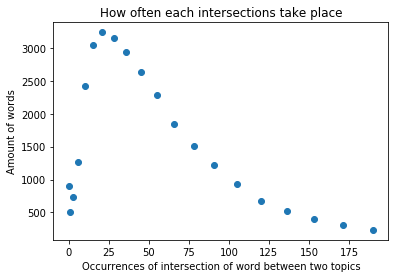

In [74]:
over_lap_distribution = {}
for word, count in sort_vocab_overlap:
    if count in over_lap_distribution:
        over_lap_distribution[count] += 1
    else:
        over_lap_distribution[count] = 1

over_lap_distribution = over_lap_distribution.items()
print(over_lap_distribution)
print("Total vocab size: " + str(sum([v[1] for v in over_lap_distribution])))

%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(*zip(*over_lap_distribution))
plt.title("How often each intersections take place")
plt.xlabel("Occurrences of intersection of word between two topics")
plt.ylabel("Amount of words")
plt.show()

# Vocab Size Comparison

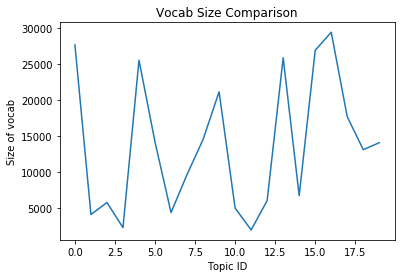

In [75]:
plt.title("Vocab Size Comparison")
plt.xlabel("Topic ID")
plt.ylabel("Size of vocab")
plt.plot([len(class_vocab[topic]) for topic in range(num_topics)])
plt.show()

# Vocab per Topic Average Frequency

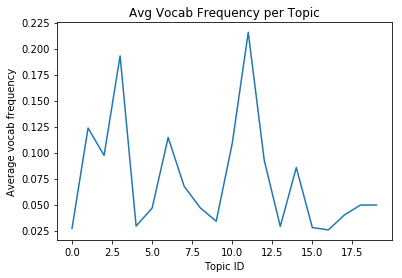

In [76]:
def get_vocab_frequency(word_list, vocab_size_full):
    freq_vocab = {}
    for line in word_list:
        for word in line:
            if word not in freq_vocab:
                freq_vocab[word] = 1
            else:
                freq_vocab[word] += 1
    # Normalize
    for word in freq_vocab:
        freq_vocab[word] = freq_vocab[word]/float(vocab_size_full)
    return freq_vocab

def get_avg_freq_per_class(freq_vocab, class_vocab):
    avg_freq = [0] * num_topics
    total = [0] * num_topics
    for topic in range(num_topics):
        for word in class_vocab[topic]:
            total[topic] += 1
            avg_freq[topic] += freq_vocab[word]
    for t in range(num_topics):
        avg_freq[t] = avg_freq[t]/total[t]
    return avg_freq


vocab_freq = get_vocab_frequency(wl_full, vocab_size_full)
avg_freq = get_avg_freq_per_class(vocab_freq, class_vocab)

plt.title("Avg Vocab Frequency per Topic")
plt.xlabel("Topic ID")
plt.ylabel("Average vocab frequency")
plt.plot([avg_freq[topic] for topic in range(num_topics)])
plt.show()

# Word Explorer

In [65]:
def find_context(word_str):
    for line in wl_full:
        for word in line:
            if word == word_str:
                print(" ")
                print([word_to_bpe_mapping[w] for w in line])
                new_doc_bow = dictionary.doc2bow(line)
                s = ldamodel.get_document_topics(new_doc_bow)
                s.sort(key=lambda x: x[1])
                t_max_class, t_max_perc = s[-1]
                print("Attributed to topic: " + str(t_max_class) + " with percentage: " + str(t_max_perc))

find_context("cool")


 
[['co', 'Co', 'OL', 'ol', 'ols', 'CO', 'cool'], ['...']]
Attributed to topic: 19 with percentage: 0.35
 
[['ino', 'Camp'], ['Al', 'AL', 'WA', 'always', 'YS', 'ways'], ['popular', 'Pop', 'ular'], ['sweet'], ['s', 'L', 'lovers', 'over'], ['adores', 'ad', 'ore'], ['que', 'uni', 'unique'], ['ity', 'ITY'], ['ta', 'taste', 'sted'], ['experience', 'EX', 'I', 'PER', 'ENCE'], ['S', 'ny', 'Sun', 'N', 'sunny', 'Y', 'UN'], ['flavour'], ['sweet'], ['FR', 'U', 'fruit', 'IT'], ['FR', 'H', 'fresh', 'ES'], ['co', 'Co', 'OL', 'ol', 'ols', 'CO', 'cool'], ['my', 'A', 'Y', 'AM', 'amy'], ['gh', 'urt', 'yo'], ['rounded'], ['subtle'], ['flower', 'F', 'lower'], ['essen', 'Essen', 'ces'], ['makes'], ['ino', 'Camp'], ['refreshing', 'ING', 'FR', 'ES', 'H', 'RE'], ['ery']]
Attributed to topic: 1 with percentage: 0.2109497
 
[['AVE', 'ave', 'Le', 'leave', 'LE'], ['co', 'Co', 'OL', 'ol', 'ols', 'CO', 'cool'], ['B', 'briefly', 'fly', 'rie'], ['ET', 'Le', 'Let', 'lets', 'ting', 't', 'le', 'L', 'let'], ['chocolate'],

Attributed to topic: 10 with percentage: 0.5125
 
[['co', 'Co', 'OL', 'ol', 'ols', 'CO', 'cool']]
Attributed to topic: 9 with percentage: 0.525
 
[['Con', 'serving', 'served', 'serve', 'con'], ['co', 'Co', 'OL', 'ol', 'ols', 'CO', 'cool'], ['Dry', 'dry'], ['PL', 'Place', 'ACE', 'placed', 'place']]
Attributed to topic: 10 with percentage: 0.21
 
[['building'], ['materials'], ['combination', 'ation', 'Com', 'bin'], ['Tim', 'timber', 'ber'], ['Ma', 'ke', 'make', 'made'], ['pression', 'impression', 'Im'], ['lose', 'ed', 'los'], ['co', 'Co', 'OL', 'ol', 'ols', 'CO', 'cool'], ['sion', 'as'], ['avour', 'favour', 'F', 'favoured'], ['co', 'Co', 'cosy', 'sier', 'sy'], ['atmosphere']]
Attributed to topic: 3 with percentage: 0.26390928
 
[['V', 'violence', 'ENCE', 'IO', 'L'], ['co', 'Co', 'OL', 'ol', 'ols', 'CO', 'cool']]
Attributed to topic: 14 with percentage: 0.35
 
[['World', 'world'], ['craft', 'warcraft', 'war'], ['versatile'], ['extensive'], ['E', 'game', 'AM', 'Game', 'games', 'G'], ['bliz

Attributed to topic: 14 with percentage: 0.32519063
 
[['belief', 'lief', 'Be'], ['id', 'Sa', 'S', 'Aid', 'aid', 's', 'said'], ['parliament'], ['AST', 'L', 'lasting', 'last'], ['occasion'], ['co', 'Co', 'OL', 'ol', 'ols', 'CO', 'cool'], ['EADS', 'H', 'heads'], ['firms', 'firm'], ['determination', 'De', 'termination'], ['much', 'M', 'H', 'UC'], ['better', 'bet', 'tered'], ['op', 'Ad', 'adopting', 'ting'], ['no', 'AN', 'another', 'OTHER', 'ther', 'A'], ['approach', 'AP', 'PRO', 'ACH']]
Attributed to topic: 10 with percentage: 0.29145697
 
[['ah', 'ye'], ['persons', 'person', 'PER', 'Son', 's', 'Person', 'SON', 'per'], ['bass'], ['player'], ['handling'], ['money', 'Money'], ['FF', 'ST', 'U', 'stuff'], ['MM', 'ER', 'mmer'], ['uty', 'duty', 'D', 'UT', 'Y'], ['KS', 'OK', 'book', 'BO', 'O'], ['ans', 'V', 'vans'], ['uring', 'S', 'TO', 'tour', 'tours', 'UR', 't', 'our', 'To', 'Tour'], ['KS', 'O', 'BO', 'books'], ['ans', 'V', 'vans'], ['drivers', 'ERS', 'DR', 'IV'], ['ah', 'ye'], ['ke', 'liked',

Attributed to topic: 7 with percentage: 0.21528754
 
[['waste', 'AS', 'stes', 'wa', 'W', 'TE'], ['heat', 'He', 'heated', 'ated', 'at', 'ats', 'he'], ['used', 'ED', 'sed', 'U', 'US'], ['ably', 'inter', 'change'], ['heat', 'He', 'heated', 'ated', 'at', 'ats', 'he'], ['co', 'Co', 'OL', 'ol', 'ols', 'CO', 'cool'], ['latter'], ['help'], ['absorption'], ['cooling', 'Co', 'oling'], ['MA', 'machine', 'CH', 'INE'], ['ID', 'ENT', 'RES', 'IAL', 'residential'], ['buildings'], ['offices', 'Off', 'ices'], ['st', 'ables', 'St']]
Attributed to topic: 10 with percentage: 0.42226008
 
[['co', 'Co', 'OL', 'ol', 'ols', 'CO', 'cool'], ['Di', 'IP', 'ps', 'D', 'p', 'di', 'pped', 'dip'], ['swimming'], ['Pool', 'OL', 'PO', 'pool', 'oling', 'po', 'oled', 'pools'], ['In', 'indulge', 'ge', 'dul'], ['pering', 'ing', 'per'], ['spa', 'S', 'pa'], ['experience', 'EX', 'I', 'PER', 'ENCE'], ['includes'], ['wide'], ['Array', 'array', 'RA', 'AR', 'Y'], ['massages'], ['died', 'body', 'bo'], ['treatments']]
Attributed to to

Attributed to topic: 10 with percentage: 0.30286103
 
[['lovely'], ['DA', 'days', 'YS'], ['F', 'lest', 'UL', 'full', 'L', 'ful'], ['uns', 'S', 'Sun', 'UN', 'sun'], ['joy', 'En', 'enjoy'], ['Times', 'Time', 'times', 'time', 'ed', 'Tim', 'T', 'IME'], ['co', 'Co', 'OL', 'ol', 'ols', 'CO', 'cool']]
Attributed to topic: 14 with percentage: 0.4194817
 
[['joy', 'En', 'enjoy'], ['largest', 'large'], ['qui', 'quiet', 'eter'], ['co', 'Co', 'OL', 'ol', 'ols', 'CO', 'cool'], ['S', 'Rooms', 'OM', 'rooms', 'RO'], ['ong', 'Al', 'AL', 'ON', 'G', 'along'], ['friend', 'liest'], ['service', 'Service'], ['WN', 'town', 'TO', 'wns', 'To'], ['free', 'Free', 'FREE'], ['F', 'lest', 'UL', 'full', 'L', 'ful'], ['ho', 'tter', 'ttest', 'hot'], ['breakfast'], ['buffet'], ['AN', 'y', 'ING', 'anything', 'TH', 'thing', 'Y', 'An'], ['Ma', 'ke', 'make', 'made'], ['stay'], ['enjoyable'], ['ET', 'Le', 'Let', 'lets', 'ting', 't', 'le', 'L', 'let'], ['know', 'new', 'K', 'NO', 'known', 'now', 'W']]
Attributed to topic: 14 w